Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
from __future__ import division
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [5]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random valued following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [6]:
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 20.131260
Training accuracy: 5.4%
Validation accuracy: 6.1%
Loss at step 100: 2.347527
Training accuracy: 71.2%
Validation accuracy: 70.7%
Loss at step 200: 1.886980
Training accuracy: 74.2%
Validation accuracy: 73.2%
Loss at step 300: 1.644544
Training accuracy: 75.7%
Validation accuracy: 74.1%
Loss at step 400: 1.481108
Training accuracy: 76.8%
Validation accuracy: 74.3%
Loss at step 500: 1.359291
Training accuracy: 77.6%
Validation accuracy: 74.6%
Loss at step 600: 1.263418
Training accuracy: 78.2%
Validation accuracy: 74.8%
Loss at step 700: 1.185224
Training accuracy: 78.5%
Validation accuracy: 74.9%
Loss at step 800: 1.119740
Training accuracy: 79.0%
Validation accuracy: 75.2%
Test accuracy: 82.2%


Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `sesion.run()`.

In [7]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [8]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 17.489958
Minibatch accuracy: 12.5%
Validation accuracy: 12.2%
Minibatch loss at step 500: 1.993229
Minibatch accuracy: 73.4%
Validation accuracy: 77.0%
Minibatch loss at step 1000: 1.266612
Minibatch accuracy: 76.6%
Validation accuracy: 76.8%
Minibatch loss at step 1500: 1.464582
Minibatch accuracy: 73.4%
Validation accuracy: 77.7%
Minibatch loss at step 2000: 1.407026
Minibatch accuracy: 72.7%
Validation accuracy: 79.0%
Minibatch loss at step 2500: 1.186520
Minibatch accuracy: 76.6%
Validation accuracy: 79.0%
Minibatch loss at step 3000: 1.143140
Minibatch accuracy: 78.1%
Validation accuracy: 78.4%
Test accuracy: 85.1%


---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units (nn.relu()) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [11]:
# Cell author : Hoang NT
# Cell : Build a neural network with 1 hidden layer with RELU unit as the activation unit.

import math

alpha = 0.2 # learning rate
num_steps = 4000
image_pixels = image_size * image_size
hidden_units = 1024

# Scale standard deriviation
# Copied from mnist.py
# TODO: Understand why they do this
def scale_dev(dsize) :
    return 1.0 / math.sqrt(float(dsize))

# Build the model as a graph with 1 hidden layer
def inference(train_data, hidden_units_num) :
    # Define variables and ops for the hidden layer
    with tf.name_scope('hidden_layer') :
        weights = tf.Variable(tf.truncated_normal([image_pixels, hidden_units_num],
                                                 stddev = scale_dev(image_pixels)),
                             name='weights')
        biases = tf.Variable(tf.zeros([hidden_units_num]), name='biases')
        hidden1 = tf.nn.relu(tf.matmul(train_data, weights) + biases)
    # Define variables and ops for the output (linear) layer
    with tf.name_scope('linear_output') :
        weights = tf.Variable(tf.truncated_normal([hidden_units_num, num_labels],
                                                 stddev = scale_dev(hidden_units_num)),
                              name='weights')
        biases = tf.Variable(tf.zeros([num_labels]), name='biases')
        logits = tf.matmul(hidden1, weights) + biases
    return logits

# Loss function for the model. The labels is expected to be in onehot
def loss(logits, labels) :
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, labels, name='xe')
    loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    return loss

# Create training operations
def training(loss, learning_rate) :
    # Create a scalar summary for loss function
    tf.scalar_summary(loss.op.name, loss)
    # Gradient descent optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # Variable to track global step
    global_step = tf.Variable(0, name='global_step', trainable=False)
    # Train operation
    train_op = optimizer.minimize(loss, global_step=global_step)
    return train_op

graph = tf.Graph()
with graph.as_default() :
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(None, image_pixels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
    
    # Computational graph
    logits = inference(tf_train_dataset, hidden_units)
    # Loss function
    loss = loss(logits, tf_train_labels)
    optimizer = training(loss, alpha)
    # Softmax layer for logits
    train_prediction = tf.nn.softmax(logits)
    
    with tf.Session() as session:
        tf.initialize_all_variables().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        valid_data = valid_dataset[:,:]
        test_data = test_dataset[:batch_size,:]
        feed_dict = {tf_train_dataset : valid_data}
        prediction = session.run(train_prediction, feed_dict=feed_dict)
        print ("Validation dataset accuracy: %.1f%%" % 
               accuracy(prediction, valid_labels[:]))
        f_data = open('sanitized_test_dataset.pickle', 'rb')
        f_labels = open('sanitized_test_labels.pickle', 'rb')
        sanitized_test_data = pickle.load(f_data)
        sanitized_test_labels = pickle.load(f_labels)
        sanitized_test_data, sanitized_test_labels = reformat(sanitized_test_data, 
                                                              sanitized_test_labels)
        feed_dict = {tf_train_dataset : sanitized_test_data}
        prediction = session.run(train_prediction, feed_dict=feed_dict)
        print ("Sanitized test dataset accuracy: %.1f%%" %
              accuracy(prediction, sanitized_test_labels))
                

Initialized
Minibatch loss at step 0: 2.327609
Minibatch accuracy: 8.6%
Minibatch loss at step 500: 0.565936
Minibatch accuracy: 83.6%
Minibatch loss at step 1000: 0.608166
Minibatch accuracy: 82.8%
Minibatch loss at step 1500: 0.510590
Minibatch accuracy: 86.7%
Minibatch loss at step 2000: 0.523633
Minibatch accuracy: 86.7%
Minibatch loss at step 2500: 0.472088
Minibatch accuracy: 84.4%
Minibatch loss at step 3000: 0.421115
Minibatch accuracy: 86.7%
Minibatch loss at step 3500: 0.378290
Minibatch accuracy: 90.6%
Validation dataset accuracy: 88.9%
Sanitized test dataset accuracy: 93.4%


TODO: Create record for TensorBoard
TODO: Visualize the weights matrix for each step

10

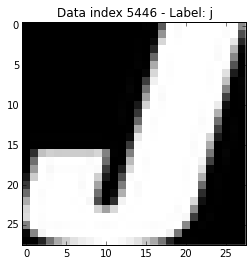

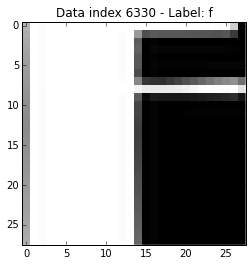

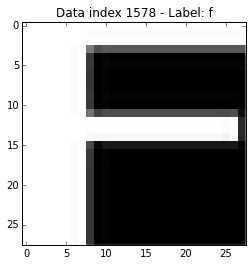

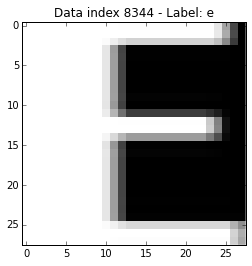

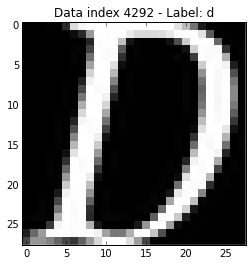

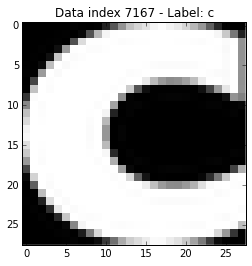

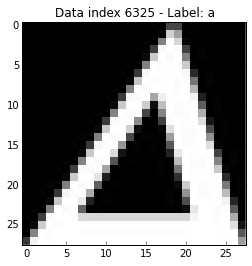

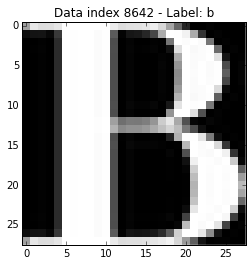

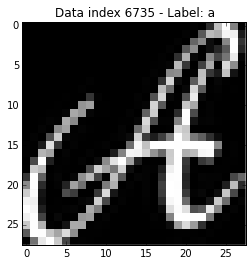

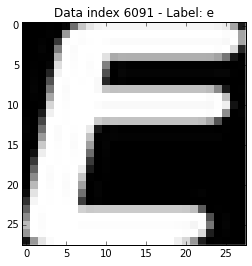

In [15]:
# Cell author : Hoang NT
# Cell : Display data and its prediction

import matplotlib.pyplot as plt
from IPython.display import display, Image
from scipy import ndimage
import random

%matplotlib inline

check_size = 10
plt.close("all")
label_lookup = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
def check_dataset(dataset, labels, test_sz) :
    data_count = 0
    data_size = len(dataset)
    if not data_size > 0 :
        print('Empty dataset')
        return data_count;
    if not data_size == len(labels) :
        raise Exception('Dataset and label do not have same size')
    indices = np.arange(data_size)
    random_data = random.sample(indices, test_sz)
    for i in random_data :
        data_count += 1
        plt.figure()
        plt.title('Data index %d - Label: %s' % (i, label_lookup[labels[i]]))
        plt.imshow(dataset[i], cmap='gray', interpolation='none')
    return data_count

def onehot_to_label(onehot) :
    return [np.argmax(x) for x in onehot]

f_data.seek(0) # Reload file
sanitized_test_data = pickle.load(f_data)
check_dataset(sanitized_test_data, onehot_to_label(prediction), check_size)